In [1]:
import sys
import os

lib_path = os.path.realpath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path = [lib_path] + sys.path
save_fig = True
savefig_path = os.path.join(lib_path, "figures/annexe_interp_Ti/")

In [2]:
from src.main_discontinu import *
from src.plot_fields import *
from src.time_problem import *

%matplotlib widget
rc("figure", figsize=(10, 5))
rc("figure", dpi=100)

# Paramètres de la simulation

Ici on va réaliser une simulation sans diffusion pour différentes écritures de notre équation thermique.

La résolution se fait à chaque fois en QUICK avec Euler explicite en temps.

La référence utilisée est une simulation TOF sur maillage fin.

In [3]:
n_lim = 10**9
t_fin_lim = 0.1

In [4]:
from copy import copy

Vtot = 0.02 * 0.005**2

phy_prop = PhysicalProperties(
    Delta=0.02,
    v=0.2,
    dS=0.005**2,
    lda1=5.5 * 10**-2,
    lda2=15.5,
    rho_cp1=70278.0,
    rho_cp2=702780.0,
    diff=1.0,
    alpha=0.06,
    a_i=357.0,
)

phy_prop_sans_conv = copy(phy_prop)
phy_prop_sans_conv.v = 0.0

nums_prop = [
    NumericalProperties(
        dx=3.5 * 10**-5,
        schema="quick",
        time_scheme="rk3",
        phy_prop=phy_prop,
        cfl=0.5,
        fo=0.5,
        interp_type=interp_type,
        conv_interf="quick",
        time_integral="exact",
    )
    for interp_type in [
        "Ti",
        "Ti2",
        # "Ti2_vol",
        "Ti3",
        # "Ti3_vol",
    ]
]

num_prop_ref = NumericalProperties(
    dx=3.5 * 10**-5, schema="weno", time_scheme="rk3", phy_prop=phy_prop, cfl=1.0
)
markerss = [
    BulleTemperature(phy_prop=phy_prop, x=num_prop.x, n_bulle=1)
    for num_prop in nums_prop
]
# for markers in markerss:
# markers.shift(0.0001)

In [5]:
init_params_ref = {
    "markers": markerss[-1],
    "phy_prop": phy_prop_sans_conv,
    "num_prop": num_prop_ref,
}
init_params = {"phy_prop": phy_prop}

# Convergence de l'opérateur ProblemDiscontinuE

On cherche a vérifier que ProblemDiscontinuE tend bien vers la solution TOF sans convection.

## Simulation comparée

In [6]:
probs_E = []
probs_TOF = []
for i in range(len(nums_prop)):
    probs_E.append(
        TimeProblem(
            get_T_creneau,
            problem_state=StateProblemDiscontinuE,
            phy_prop=phy_prop,
            num_prop=nums_prop[i],
            markers=markerss[i],
        )
    )
    probs_TOF.append(
        TimeProblem(
            get_T_creneau,
            problem_state=StateProblem,
            phy_prop=phy_prop,
            num_prop=nums_prop[i],
            markers=markerss[i],
        )
    )

prob_ref = TimeProblem(get_T_creneau, **init_params_ref, problem_state=StateProblem)


Energie
dt fourier
2.7812848789747498e-06
Db / dx = 34
Monofluid convection :  quick
Interface interp type :  Ti
Face interp :  quick
Time integration method for surfaces : exact

TOF
===
dt fourier
2.7812848789747498e-06
Db / dx = 34
Monofluid convection :  quick

Energie
dt fourier
2.7812848789747498e-06
Db / dx = 34
Monofluid convection :  quick
Interface interp type :  Ti2
Face interp :  quick
Time integration method for surfaces : exact

TOF
===
dt fourier
2.7812848789747498e-06
Db / dx = 34
Monofluid convection :  quick

Energie
dt fourier
2.7812848789747498e-06
Db / dx = 34
Monofluid convection :  quick
Interface interp type :  Ti3
Face interp :  quick
Time integration method for surfaces : exact

TOF
===
dt fourier
2.7812848789747498e-06
Db / dx = 34
Monofluid convection :  quick

TOF
===
dt fourier
5.5625697579494996e-06
Db / dx = 34
Monofluid convection :  weno


Liste des simus similaires : 
['../References/TOF, rk3, weno, dx = 3.50263e-05, dt = 5.6e-06_t_0.099998.pkl']
Liste des simus similaires : 
['../References/TOF, rk3, weno, dx = 3.50263e-05, dt = 5.6e-06_t_0.099998.pkl']
Loading ======> ../References/TOF, rk3, weno, dx = 3.50263e-05, dt = 5.6e-06_t_0.099998.pkl
remaining time to compute : 0.000002
Liste des simus similaires : 
['../References/statistics_TOF, rk3, weno, dx = 3.50263e-05, dt = 5.6e-06_t_0.099998.pkl']


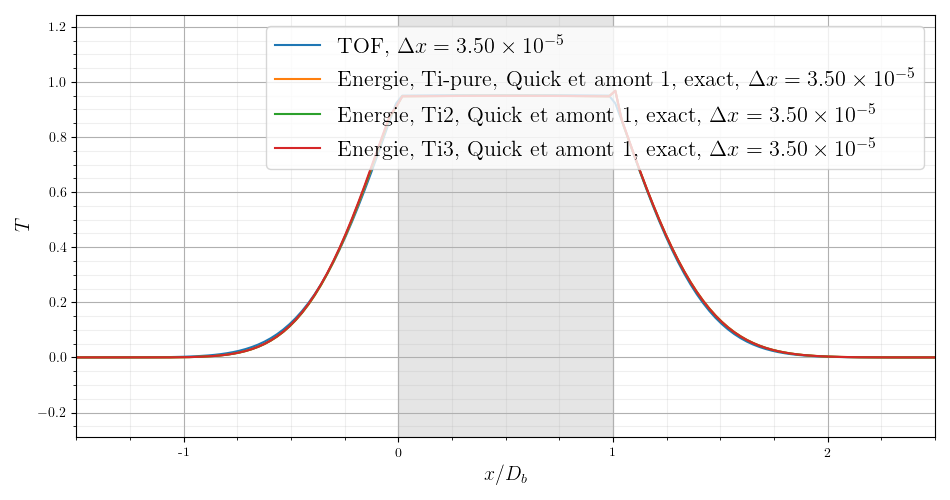

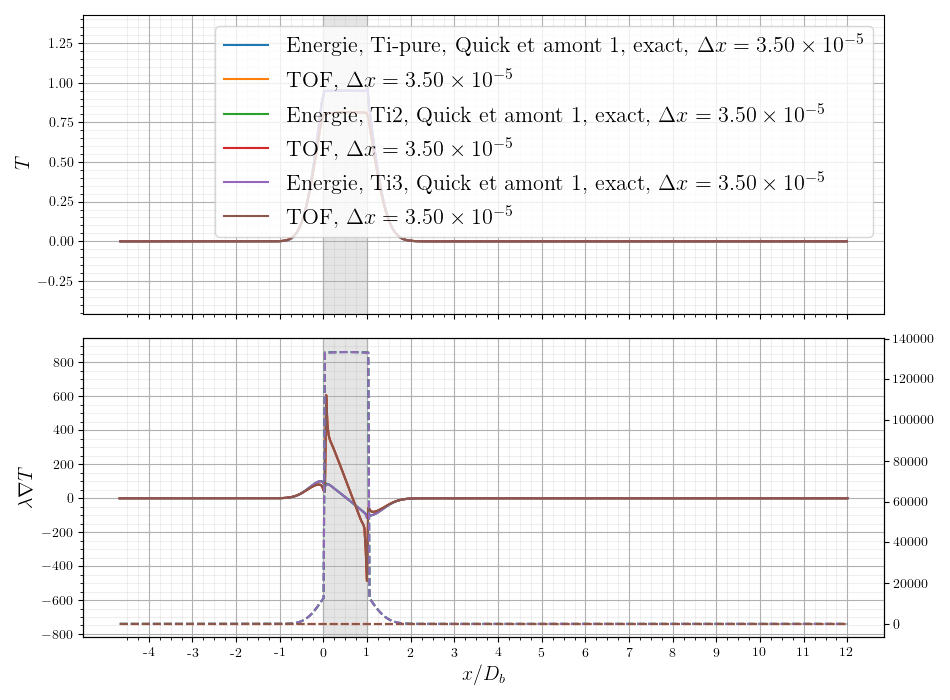

In [7]:
t_fin = 0.1

plot_tot = Plotter(
    "decale", flux_conv=False, lda_gradT=False, zoom=(-1.5, 2.5), dx=True, time=False
)
plot_1 = Plotter("decale", flux_conv=True, lda_gradT=True, dx=True, time=False)

time_args = {"t_fin": min(t_fin, t_fin_lim), "n": n_lim, "number_of_plots": 1}

t_ref, e_ref = prob_ref.load_or_compute(**time_args, plotter=[plot_tot])

for i, prob_E in enumerate(probs_E):
    prob_E.timestep(**time_args, plotter=[plot_1, plot_tot])
    probs_TOF[i].timestep(**time_args, plotter=[plot_1])

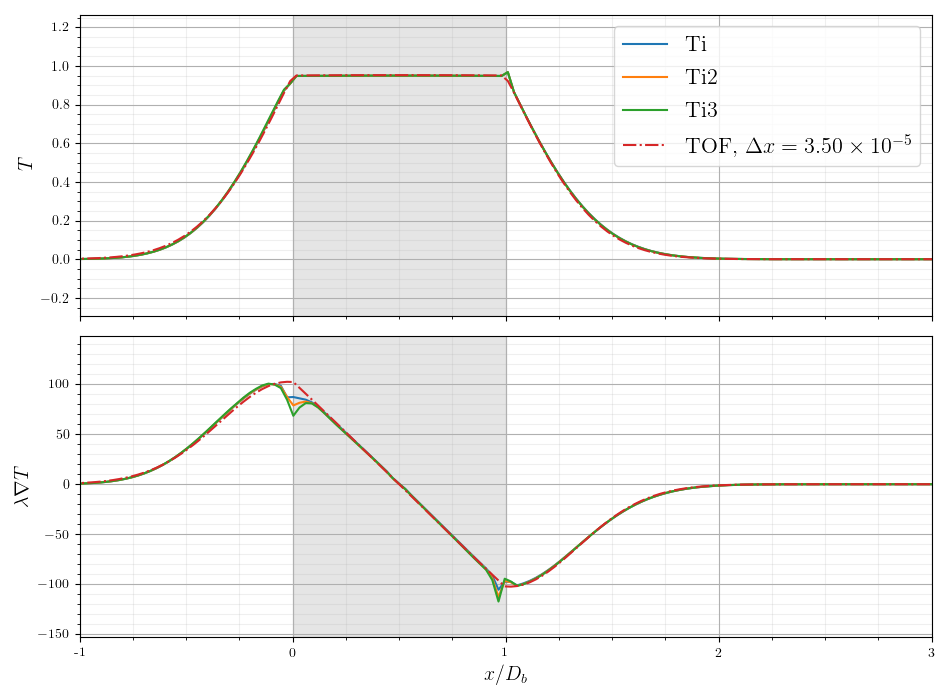

In [8]:
plotter = Plotter(
    "classic",
    flux_conv=False,
    lda_gradT=True,
    dx=True,
    time=False,
    ispretty=True,
    zoom=(-1, 3),
)
# plotter.plot(prob_ref)
for pb in probs_E:
    plotter.plot(
        pb.problem_state, label=pb.problem_state.interp_type.replace("_vol", " vol")
    )
plotter.plot(prob_ref.problem_state, plot_Ti=False, ls="-.")
if save_fig:
    plotter.fig.savefig(savefig_path + "comparaison_interpolation_Ti.pdf")